### Deutsch-Jozsa

In [36]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

In [37]:
def build_oracle(n: int, kind: str) -> QuantumCircuit:
    """
    n   : 問題量子ビットの数
    kind: 'const_0', 'const_1', 'balanced_parity', 'balanced_subset'
    """
    oracle = QuantumCircuit(n + 1)          # 問題 n + 補助 1

    if kind == "const_0":
        # 何もしない（常に 0）――  U_f |x>|y> = |x>|y>
        pass

    elif kind == "const_1":
        # 常に 1 ―― U_f |x>|y> = |x>|y ⊕ 1>
        oracle.x(n)                         # 補助量子に X

    elif kind == "balanced_parity":
        # f(x) = x0 ⊕ x1 ⊕ … ⊕ x{n-1}  （偶奇パリティ）
        # 多重制御 X (MCX) でまとめても良いが，単純に CX を列挙
        for i in range(n):
            oracle.cx(i, n)                 # 各問題量子を制御にして補助量子へ

    elif kind == "balanced_subset":
        # 例: f(x) = x0 （入力の 1 ビット目そのもの）
        oracle.cx(0, n)                     # q0 を制御に CX

    else:
        raise ValueError("unknown oracle kind")

    oracle.name = f"U_f({kind})"
    return oracle


In [38]:
def deutsch_jozsa_circuit(n: int, oracle_kind: str) -> QuantumCircuit:
    qc = QuantumCircuit(n + 1, n)

    # ①初期化 |0…0⟩|1⟩
    qc.x(n)
    qc.h(n)

    # ②問題量子ビットを |+⟩ に
    qc.h(range(n))

    # ③オラクル
    oracle = build_oracle(n, oracle_kind).to_gate()
    qc.append(oracle, qc.qubits)

    # ④再び H を各問題量子に
    qc.h(range(n))

    # ⑤測定
    qc.measure(range(n), range(n))
    return qc


In [ ]:
def run_dj(n: int, oracle_kind: str, shots: int = 1024):
    qc = deutsch_jozsa_circuit(n, oracle_kind)
    display(qc.draw("mpl", style="iqp"))

    sim = AerSimulator() 
    tqc = transpile(qc, sim)
    result = sim.run(tqc, shots=shots).result()
    counts = result.get_counts()  

    key = max(counts, key=counts.get)
    if key == "0"*n:
        print("→ oracle is CONSTANT")
    else:
        print("→ oracle is BALANCED")


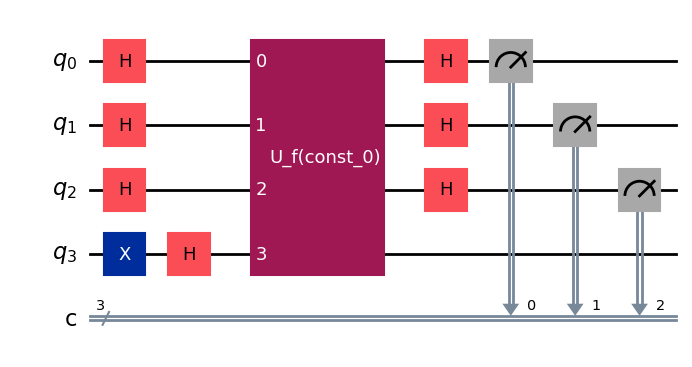

→ oracle is CONSTANT


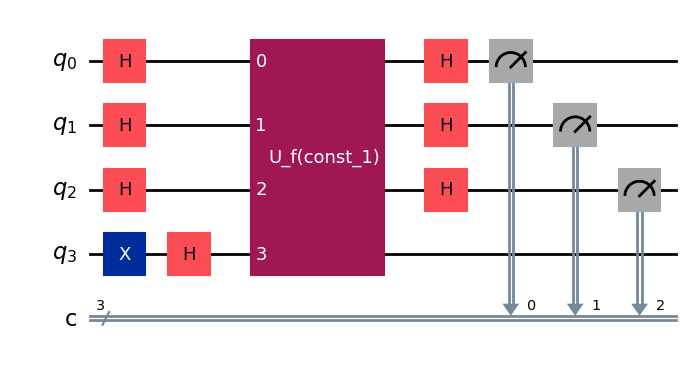

→ oracle is CONSTANT


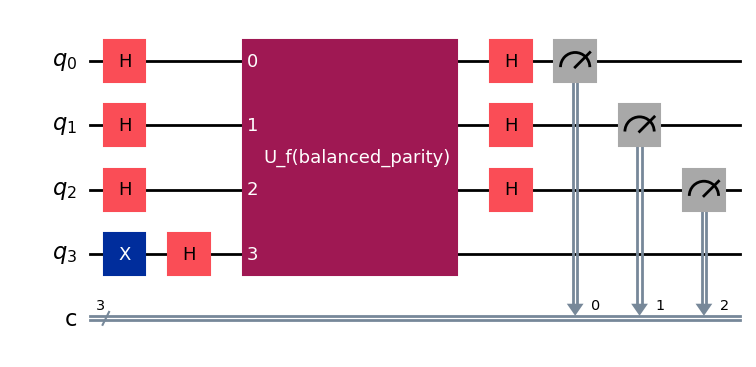

→ oracle is BALANCED


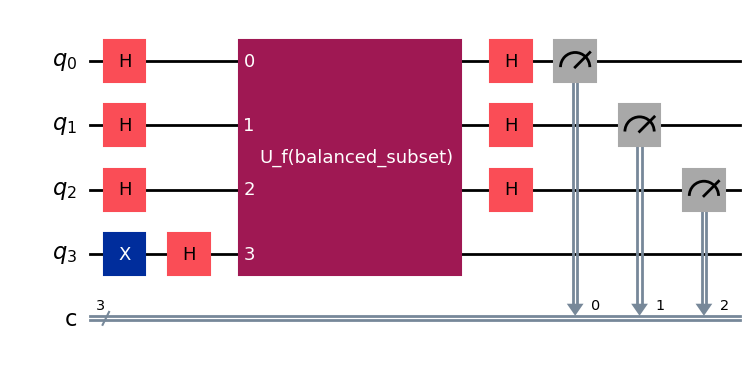

→ oracle is BALANCED


In [ ]:
n = 3
run_dj(n, "const_0")
run_dj(n, "const_1")
run_dj(n, "balanced_parity")
run_dj(n, "balanced_subset")


In [ ]:
from qiskit import QuantumCircuit
from qiskit.visualization import circuit_drawer

def show_oracle(n: int, kind: str, output: str = "text") -> QuantumCircuit:
    qc = build_oracle(n, kind)

    if output == "text":
        print(f"\n### U_f({kind})  n={n}\n")
        print(qc.draw(output="text"))
    elif output in ("mpl", "latex"):
        circuit_drawer(qc, output=output)
    else:
        raise ValueError("output must be 'text', 'mpl', or 'latex'")

    return qc


if __name__ == "__main__":
    kinds = ["const_0", "const_1", "balanced_parity", "balanced_subset"]
    for k in kinds:
        show_oracle(n=3, kind=k, output="text")



### U_f(const_0)  n=3

     
q_0: 
     
q_1: 
     
q_2: 
     
q_3: 
     

### U_f(const_1)  n=3

          
q_0: ─────
          
q_1: ─────
          
q_2: ─────
     ┌───┐
q_3: ┤ X ├
     └───┘

### U_f(balanced_parity)  n=3

                    
q_0: ──■────────────
       │            
q_1: ──┼────■───────
       │    │       
q_2: ──┼────┼────■──
     ┌─┴─┐┌─┴─┐┌─┴─┐
q_3: ┤ X ├┤ X ├┤ X ├
     └───┘└───┘└───┘

### U_f(balanced_subset)  n=3

          
q_0: ──■──
       │  
q_1: ──┼──
       │  
q_2: ──┼──
     ┌─┴─┐
q_3: ┤ X ├
     └───┘
